In [10]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import time 

URL = "https://www.oref.org.il//Shared/Ajax/GetAlarmsHistory.aspx"
FROM_DATE = '7.10.23'
TO_DATE = '11.11.23'
DAYS_INTERVAL = 2
CSV_FILE_PATH = "C:/Projects/Python/Projects/BestTimeToShower/data/data.csv"
SLEEP_TIME = 5

In [11]:
def get_user_settlement():
    user_settlment = input("Please input the settlement where you would like to map the distribution of alarms\n"
                           "here ---> ")
    return user_settlment

def get_request(current_date, dest_date, alerts_list):
    try:    
        params = {'lang':'en',
                    'fromDate': current_date,
                    'toDate': dest_date,
                    'mode': '0'}
        response = requests.get(URL, params=params)
        if response.status_code == 200:
            time.sleep(SLEEP_TIME)
            current_alerts_list = json.loads(response.text)
            alerts_list += current_alerts_list
        else:
            response.raise_for_status()
        
    except requests.HTTPError as e:
        print(f"HTTP error occurred: {e}")    

def get_oref_alarms(from_date, to_date):
    all_time_alarams_list = []
    current_date = datetime.strptime(from_date, '%d.%m.%y')
    target_date = datetime.strptime(to_date, '%d.%m.%y')
    print(current_date)
    while current_date <= target_date:
        dest_date = current_date + timedelta(days=DAYS_INTERVAL)  
        get_request(current_date, dest_date, all_time_alarams_list)
        print(f"Get the alarms from date: {current_date} to date: {dest_date}")
        current_date += timedelta(days=DAYS_INTERVAL)
    
    difference = current_date - target_date
    days_diff = difference.days
    day_to_add = DAYS_INTERVAL-days_diff
    current_date -= timedelta(days=DAYS_INTERVAL) # return current_date to the correct date cause we add DAYS_INTERVAL at the end of while loop
    get_request(current_date, current_date + timedelta(days=day_to_add), all_time_alarams_list)
    
    df = pd.DataFrame(all_time_alarams_list)
    df.to_csv(CSV_FILE_PATH)
    
     
get_oref_alarms(FROM_DATE, TO_DATE)

2023-10-07 00:00:00
Get the alarms from date: 2023-10-07 00:00:00 to date: 2023-10-09 00:00:00
Get the alarms from date: 2023-10-09 00:00:00 to date: 2023-10-11 00:00:00
Get the alarms from date: 2023-10-11 00:00:00 to date: 2023-10-13 00:00:00
Get the alarms from date: 2023-10-13 00:00:00 to date: 2023-10-15 00:00:00
Get the alarms from date: 2023-10-15 00:00:00 to date: 2023-10-17 00:00:00
Get the alarms from date: 2023-10-17 00:00:00 to date: 2023-10-19 00:00:00
Get the alarms from date: 2023-10-19 00:00:00 to date: 2023-10-21 00:00:00
Get the alarms from date: 2023-10-21 00:00:00 to date: 2023-10-23 00:00:00
Get the alarms from date: 2023-10-23 00:00:00 to date: 2023-10-25 00:00:00
Get the alarms from date: 2023-10-25 00:00:00 to date: 2023-10-27 00:00:00
Get the alarms from date: 2023-10-27 00:00:00 to date: 2023-10-29 00:00:00
Get the alarms from date: 2023-10-29 00:00:00 to date: 2023-10-31 00:00:00
Get the alarms from date: 2023-10-31 00:00:00 to date: 2023-11-02 00:00:00
Get t

In [12]:
def display_dist(df, settlment):
    # Access the 'time' column of the DataFrame
    df['time'] = pd.to_datetime(df['time'])

    # Plot histogram
    plt.hist(df['time'].dt.hour + df['time'].dt.minute / 60, bins=4 * 24, range=(0, 24), color='skyblue', edgecolor='black')

    plt.xlabel('Time')
    plt.ylabel('Alarms')
    plt.title(f"Distribution of alarms in {settlment}")
    # Set X-axis ticks and labels
    plt.xticks(range(24), labels=[str(i) for i in range(24)])
    plt.show()

In [13]:
def return_data_list(dataframe):
    items_lst = dataframe['data'].tolist()
    return items_lst


In [14]:
def create_user_settl_lst(given_lst, settlement_name):
    settl_lst = []
    for item in given_lst:
        if settlement_name.lower() in item.lower():
            if item.lower() not in settl_lst:
                settl_lst.append(item.lower())
    return settl_lst

In [15]:
def main():
    try:    
        dataframe = pd.read_csv(CSV_FILE_PATH) 
        print(dataframe.shape)

        data_items_lst = return_data_list(dataframe)
        #print(data_items_lst)

        user_inp = get_user_settlement()
        print(f"You selected: {user_inp}")

        #df = pd.DataFrame(dataframe)

        # The user can input values whether they are lowercase or uppercase and it will work fine
        dataframe['data'] = dataframe['data'].str.lower()
        print(dataframe)
        settlement_lst= create_user_settl_lst(data_items_lst, user_inp)
        #print(settlement_lst)
        
        if settlement_lst != []:
            # Filtered the df by the given settlement lst
            filtered_df = dataframe[dataframe['data'].isin(settlement_lst)]
            
            display_dist(filtered_df, user_inp)
    
        else:
            raise ValueError("You selected a Settlement that does not exist.")
        
       
    except ValueError as e:
        print(f"An error occured: {e}")


(8120, 9)


You selected: sderot
      Unnamed: 0                               data        date      time  \
0              0                              einav  09.10.2023  22:00:15   
1              1  ashkelon southern industrial zone  09.10.2023  21:07:17   
2              2  ashkelon southern industrial zone  09.10.2023  20:31:07   
3              3                     netiv haassara  09.10.2023  20:31:07   
4              4                             karmia  09.10.2023  20:31:07   
...          ...                                ...         ...       ...   
8115        8115                              nirim  10.11.2023  08:38:35   
8116        8116                             alumim  10.11.2023  02:43:04   
8117        8117                              sa'ad  10.11.2023  02:43:04   
8118        8118                          nachal oz  10.11.2023  02:43:04   
8119        8119                          kfar azza  10.11.2023  02:43:04   

                alertDate  category           category

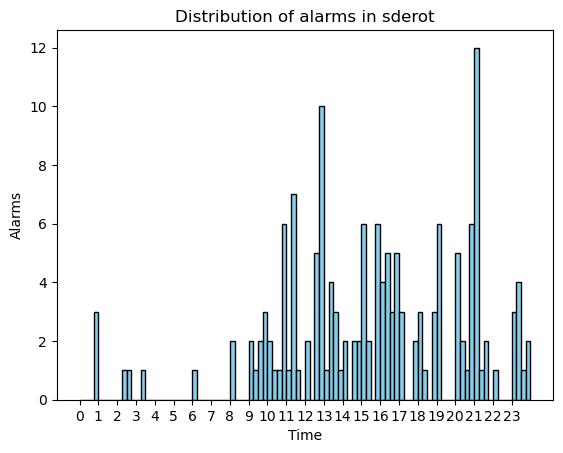

In [16]:
if __name__ == "__main__":
    main()